# DATA UNDERSTANDING

Pada tahap ini akan memahami struktur dan isi dari dataset **Online Retail** yang bersumber dari [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail).

Dataset ini berisi transaksi e-commerce dari perusahaan retail Inggris antara tahun 2010 dan 2011. Informasi yang tersedia mencakup transaksi penjualan, deskripsi produk, jumlah pembelian, identitas pelanggan, dan negara asal.

Berikut adalah fitur-fitur pada dataset:

- **InvoiceNo**: Nomor faktur. Jika diawali dengan huruf 'C' maka itu adalah pembatalan.
- **StockCode**: Kode unik untuk setiap produk.
- **Description**: Deskripsi atau nama produk.
- **Quantity**: Jumlah produk yang dibeli.
- **InvoiceDate**: Tanggal dan waktu transaksi.
- **UnitPrice**: Harga per unit produk (dalam Pound Sterling).
- **CustomerID**: Nomor unik pelanggan.
- **Country**: Negara tempat pelanggan berada.


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Memuat dataset
df = pd.read_csv('/content/drive/MyDrive/sistem_rekomendasi/Online Retail - Online Retail.csv')

# Menampilkan 5 baris pertama dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
# Informasi umum dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Kesimpulan:

Berdasarkan hasil output `df.info()`, kita dapat mengetahui beberapa hal penting terkait struktur dataset:

- Dataset terdiri dari **541.909 baris** dan **8 kolom**.
- Kolom **`Description`** memiliki sekitar 1.454 baris data yang kosong.
- Kolom **`CustomerID`** memiliki jumlah missing value yang signifikan (sekitar 135.000 baris).
- Tipe data:
  - `InvoiceNo`, `StockCode`, `Description`, dan `Country` bertipe **object** (teks/kategori).
  - `Quantity` bertipe **int64**.
  - `UnitPrice` dan `CustomerID` bertipe **float64**.
  - `InvoiceDate` bertipe **datetime64**, yang menunjukkan adanya informasi waktu dalam data.

📌 *Insight awal:*
- Perlu dilakukan pembersihan data, terutama pada kolom `Description` dan `CustomerID` yang memiliki missing value.
- Karena `CustomerID` sangat penting untuk membangun sistem rekomendasi berbasis pengguna (Collaborative Filtering), kita akan mempertimbangkan untuk memfilter data hanya pada baris yang memiliki nilai `CustomerID`.


In [5]:
# Statistik deskriptif numerik
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Kesimpulan:

Output `df.describe()` memberikan ringkasan statistik deskriptif untuk kolom numerik dalam dataset:

 Kolom `Quantity`
- **Min**: -80.995 — terdapat nilai negatif, kemungkinan merupakan transaksi retur.
- **Mean**: 9.55 — rata-rata jumlah barang yang dibeli adalah sekitar 9 unit.
- **Max**: 80.995 — nilai maksimum menunjukkan pembelian dalam jumlah besar.
- **Std**: 218 — standar deviasi yang besar menunjukkan data sangat menyebar dan kemungkinan ada outlier.

Kolom `InvoiceDate`
- Data `InvoiceDate` sudah bertipe datetime, namun nilai statistik seperti `mean`, `25%`, dan lainnya ditampilkan dalam format waktu. Ini hanya bersifat informatif dan tidak relevan untuk analisis statistik secara langsung.

Kolom `UnitPrice`
- **Min**: -11.062 — harga negatif tidak logis dan mengindikasikan kesalahan atau retur.
- **Mean**: 4.61 — rata-rata harga produk sekitar 4.6 (dalam satuan mata uang dataset, kemungkinan Poundsterling).
- **Max**: 38.970 — ada produk dengan harga sangat tinggi yang bisa menjadi outlier.
- **Std**: 96.76 — variasi harga sangat tinggi, perlu diwaspadai saat melakukan analisis lanjutan.

Kolom `CustomerID`
- **Count**: 406.829 — jumlah pelanggan unik yang terdata sebagian (karena banyak missing).
- **Min & Max**: Rentang ID pelanggan dari 12346 hingga 18287.
- **Mean & Std**: Nilai-nilai ini tidak terlalu penting karena ID bukan data numerik untuk analisis statistik biasa.

📌 *Insight awal:*
- Terdapat outlier dan nilai-nilai yang tidak valid (negatif) pada kolom `Quantity` dan `UnitPrice` yang perlu dibersihkan.
- Data `CustomerID` yang kosong bisa di-drop jika ingin menggunakan pendekatan Collaborative Filtering.
- `InvoiceDate` akan lebih berguna bila diolah untuk analisis temporal seperti tren pembelian berdasarkan waktu.



In [6]:
# Jumlah baris dan kolom dataset awal
print(f"Dataset memiliki {df.shape[0]} baris dan {df.shape[1]} kolom.\n")

# Cek jumlah missing value per kolom
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

Dataset memiliki 541909 baris dan 8 kolom.

Jumlah missing value per kolom:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


**Struktur Dataset**

Dataset memiliki **541.909 baris** dan **8 kolom**. Berikut adalah ringkasan jumlah missing value pada tiap kolom:

- `Description`: 1.454 nilai kosong
- `CustomerID`: 135.080 nilai kosong

Kehadiran missing value ini akan dipertimbangkan dalam proses **Data Preparation**, terutama untuk pemodelan berbasis pelanggan (Collaborative Filtering).


#  EDA

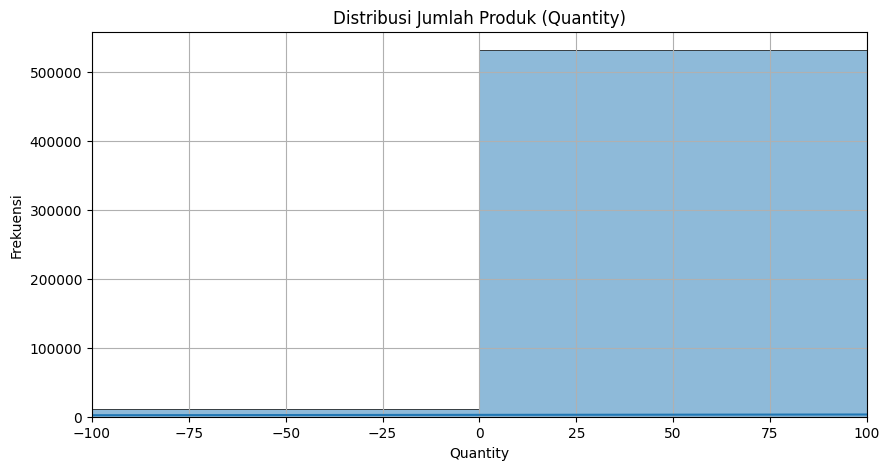

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['Quantity'], bins=100, kde=True)
plt.title('Distribusi Jumlah Produk (Quantity)')
plt.xlabel('Quantity')
plt.ylabel('Frekuensi')
plt.xlim(-100, 100)  # fokus ke range kecil untuk visualisasi awal
plt.grid(True)
plt.show()


Kesimpulan:

1. Nilai Negatif:

- Nilai-nilai negatif (Quantity < 0) kemungkinan besar merupakan retur atau pembatalan pembelian.

- Perlu dipertimbangkan apakah akan: Disimpan untuk analisis retur, atau Dihapus jika hanya ingin menganalisis pembelian bersih.

2. Skewed Distribution:

- Distribusi sangat skewed ke kanan (right-skewed), artinya ada beberapa transaksi dengan pembelian dalam jumlah sangat besar (outlier), tapi mayoritas adalah pembelian kecil.

- Visualisasi menggunakan xlim(-100, 100) membuat distribusi utama lebih terlihat, tapi nilai ekstrim tidak ikut divisualisasikan penuh.



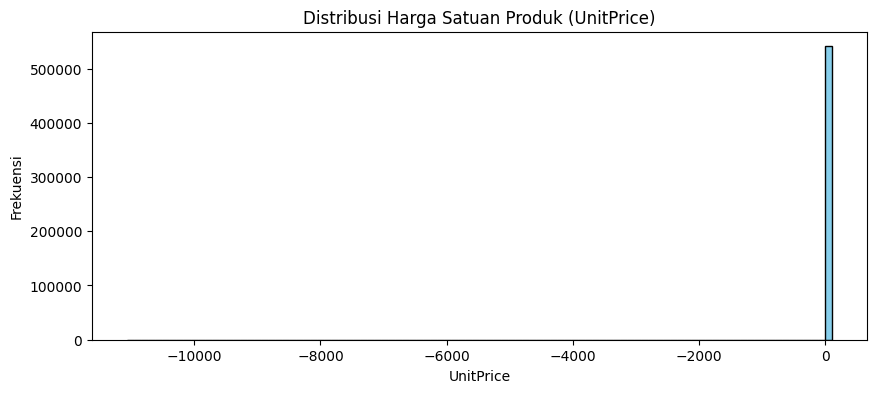

In [8]:
plt.figure(figsize=(10, 4))
df[df['UnitPrice'] < 100]['UnitPrice'].hist(bins=100, color='skyblue', edgecolor='black')
plt.title('Distribusi Harga Satuan Produk (UnitPrice)')
plt.xlabel('UnitPrice')
plt.ylabel('Frekuensi')
plt.grid(False)
plt.show()


kesimpulan:

UnitPrice adalah harga satuan dari masing-masing produk yang tercatat dalam dataset.

Dari statistik sebelumnya (describe()):

- Rata-rata harga produk: ± £4.61

- Harga maksimum: £38,970

- Ada harga negatif (-£11,062) → ini tidak wajar.



<ipython-input-11-94226950bce9>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')


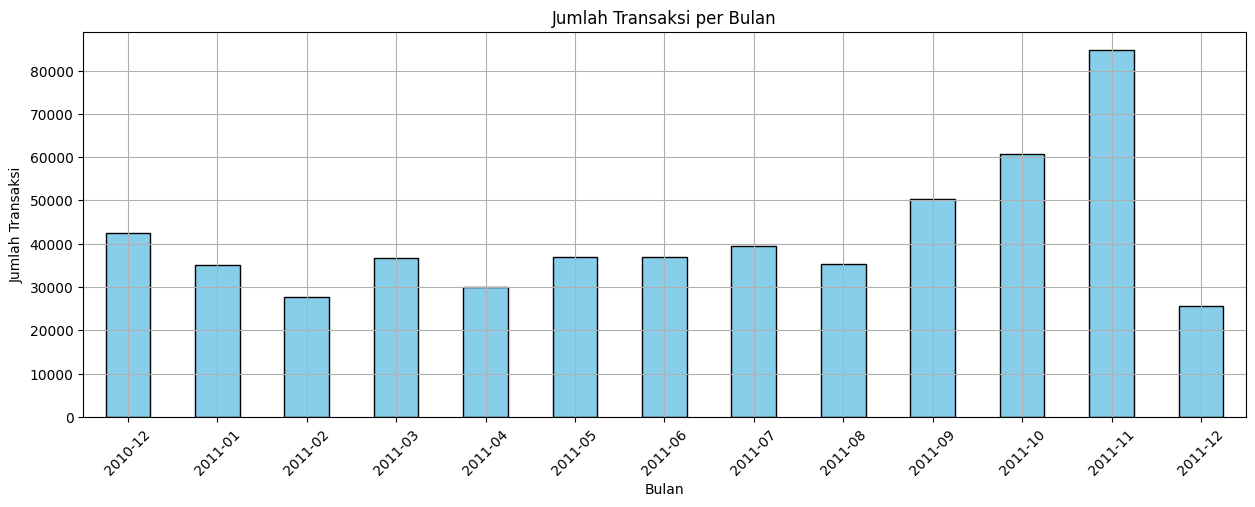

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Pastikan kolom InvoiceDate bertipe datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Lalu baru buat kolom InvoiceMonth
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

monthly_orders = df.groupby('InvoiceMonth').size()

monthly_orders.plot(kind='bar', figsize=(15, 5), color='skyblue', edgecolor='black')
plt.title('Jumlah Transaksi per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Kesimpulan:

- Tren penjualan meningkat saat mendekati akhir tahun (karena musim belanja seperti Natal) dari bulan 9 sampai bulan 11.

- Penurunan tajam pada bulan Desember 2011, karena data berhenti di tanggal 9.

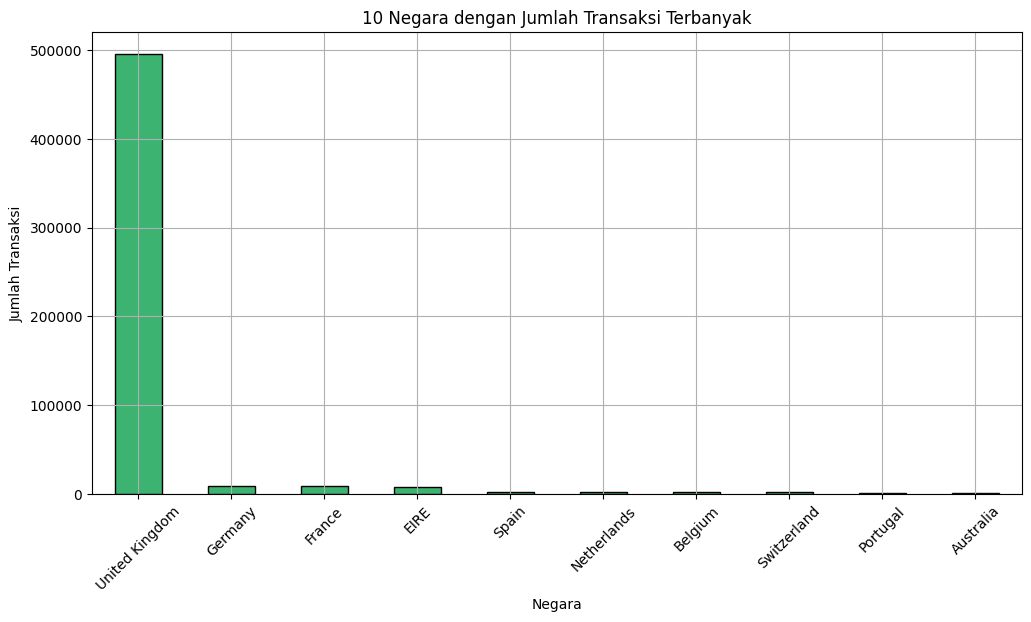

In [12]:
country_counts = df['Country'].value_counts()

plt.figure(figsize=(12,6))
country_counts.head(10).plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('10 Negara dengan Jumlah Transaksi Terbanyak')
plt.xlabel('Negara')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Kesimpulan:

- United Kingdom (UK) memiliki jumlah transaksi tertinggi karena perusahaan ini berbasis di UK.

- Negara lain seperti Germany, France, EIRE, dan Spain sering muncul di posisi 5 besar.

- Negara dengan transaksi sedikit (1–5 transaksi) bisa dipertimbangkan sebagai outlier atau diabaikan untuk analisis global.

# DATA PREPROCESSING

In [13]:
# Salin data untuk preprocessing
df_clean = df.copy()

# Hapus baris yang memiliki missing value pada CustomerID dan Description
df_clean.dropna(subset=['CustomerID', 'Description'], inplace=True)

# Tampilkan jumlah baris setelah penghapusan
print(f"Jumlah baris setelah menghapus NaN pada CustomerID & Description: {df_clean.shape[0]}")

Jumlah baris setelah menghapus NaN pada CustomerID & Description: 406829


**Menghapus Nilai Kosong**

Kolom `CustomerID` dan `Description` merupakan informasi penting yang diperlukan untuk sistem rekomendasi. Oleh karena itu, baris yang memiliki nilai kosong (`NaN`) pada kolom ini dihapus.

Jumlah baris data setelah menghapus missing value adalah 406829.


In [14]:
# Hapus transaksi yang Invoice-nya dibatalkan (mengandung "C")
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.contains('C')]

# Tampilkan jumlah baris setelah penghapusan
print(f"Jumlah baris setelah menghapus transaksi dibatalkan: {df_clean.shape[0]}")

Jumlah baris setelah menghapus transaksi dibatalkan: 397924


**Menghapus Transaksi yang Dibatalkan**

Transaksi yang dibatalkan ditandai dengan `InvoiceNo` yang mengandung huruf "C". Data seperti ini tidak diperlukan dalam proses pembuatan sistem rekomendasi karena tidak mencerminkan pembelian sebenarnya. Oleh karena itu, transaksi ini dihapus dari dataset.


In [15]:
# Filter hanya nilai Quantity dan UnitPrice yang valid (> 0)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Tampilkan jumlah baris setelah pembersihan
print(f"Jumlah baris setelah menghapus Quantity/UnitPrice <= 0: {df_clean.shape[0]}")


Jumlah baris setelah menghapus Quantity/UnitPrice <= 0: 397884


**Menghapus Data yang Tidak Valid**

Beberapa transaksi memiliki nilai `Quantity` dan `UnitPrice` yang kurang dari atau sama dengan nol. Nilai ini tidak valid dalam konteks pembelian, sehingga baris tersebut dihapus dari dataset.


In [16]:
# Buat kolom TotalPrice dari Quantity x UnitPrice
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Cek hasil kolom baru
df_clean[['Quantity', 'UnitPrice', 'TotalPrice']].head()


,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


**Menambahkan Fitur Baru: TotalPrice**

Fitur `TotalPrice` dihitung dari hasil perkalian antara `Quantity` dan `UnitPrice`. Fitur ini penting untuk mengetahui total nilai transaksi dari setiap item yang dibeli oleh pelanggan, yang nantinya dapat digunakan untuk analisis dan sistem rekomendasi.


# DATA PREPARATION

**Data Preparation**

Setelah data dibersihkan, langkah selanjutnya adalah mempersiapkan data untuk digunakan dalam dua pendekatan sistem rekomendasi:

- **Content-Based Filtering**, yang menggunakan deskripsi produk sebagai fitur utama.
- **Collaborative Filtering**, yang menggunakan interaksi historis antara pengguna dan produk.

Berikut adalah langkah-langkah yang dilakukan:
1. Encoding kolom `CustomerID` dan `Description`.
2. Menggunakan TF-IDF untuk memproses teks deskripsi produk.
3. Membuat interaction matrix antara pelanggan dan produk.
4. Split data untuk pelatihan dan evaluasi model.


## LABEL ENCODING

In [17]:
from sklearn.preprocessing import LabelEncoder

# Label encoding untuk CustomerID
user_encoder = LabelEncoder()
df_clean['CustomerIdx'] = user_encoder.fit_transform(df_clean['CustomerID'])

# Label encoding untuk Description
product_encoder = LabelEncoder()
df_clean['ProductIdx'] = product_encoder.fit_transform(df_clean['Description'])

# Tampilkan hasil encode
df_clean[['CustomerID', 'CustomerIdx', 'Description', 'ProductIdx']].head()

,CustomerID,CustomerIdx,Description,ProductIdx
0,17850.0,4016,WHITE HANGING HEART T-LIGHT HOLDER,3698
1,17850.0,4016,WHITE METAL LANTERN,3706
2,17850.0,4016,CREAM CUPID HEARTS COAT HANGER,858
3,17850.0,4016,KNITTED UNION FLAG HOT WATER BOTTLE,1804
4,17850.0,4016,RED WOOLLY HOTTIE WHITE HEART.,2763


**Encoding ID Pengguna dan Produk**

Untuk memudahkan pemrosesan data dalam model machine learning, kolom `CustomerID` dan `Description` diubah menjadi angka dengan Label Encoding. Hasilnya disimpan ke dalam kolom `CustomerIdx` dan `ProductIdx`.


## TF-IDF



In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF untuk deskripsi produk
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_clean['Description'])

# Menampilkan bentuk matriks TF-IDF
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (397884, 1971)


**Membuat Representasi Fitur Deskripsi Produk**

TF-IDF digunakan untuk mengubah teks pada kolom `Description` menjadi vektor numerik yang bisa dibandingkan menggunakan cosine similarity. Teknik ini penting untuk model Content-Based Filtering.


In [19]:
# Membuat dataframe interaksi untuk Collaborative Filtering
interaction_df = df_clean.groupby(['CustomerIdx', 'ProductIdx'])['Quantity'].sum().reset_index()

# Lihat hasil agregasi interaksi
interaction_df.head()


,CustomerIdx,ProductIdx,Quantity
0,0,1992,74215
1,1,70,126
2,1,72,12
3,1,73,12
4,1,109,72


**Membuat Dataframe Interaksi Pelanggan-Produk**

Untuk model Collaborative Filtering, dibutuhkan data interaksi antara pengguna dan produk. Di sini, interaksi didefinisikan sebagai jumlah `Quantity` produk yang dibeli oleh setiap pelanggan.


In [20]:
from sklearn.model_selection import train_test_split

# Membagi data interaksi menjadi training dan test
train_data, test_data = train_test_split(interaction_df, test_size=0.2, random_state=42)

print(f"Jumlah data train: {len(train_data)}")
print(f"Jumlah data test: {len(test_data)}")

Jumlah data train: 214628
Jumlah data test: 53657


**Membagi Data Interaksi untuk Training dan Evaluasi**

Data interaksi dibagi menjadi dua bagian: data pelatihan dan data pengujian. Pembagian ini bertujuan untuk mengevaluasi performa model Collaborative Filtering menggunakan metrik seperti RMSE dan Precision@K.


# MODELLING

**Modeling**

Pada tahap ini akan membangun dua pendekatan sistem rekomendasi:

1. **Content-Based Filtering**: Menganalisis kesamaan antar produk berdasarkan fitur deskripsi teks menggunakan TF-IDF dan cosine similarity.
2. **Collaborative Filtering**: Memprediksi preferensi pengguna berdasarkan interaksi historis menggunakan algoritma SVD (Singular Value Decomposition) dari pustaka Surprise.

Setiap pendekatan akan diberikan tahapan modeling yang terpisah untuk memudahkan pemahaman dan evaluasi.


##  Content-Based Filtering

In [31]:
from sklearn.metrics.pairwise import linear_kernel
def get_recommendations(product_name, top_n=5):
    try:
        idx = df_clean[df_clean['Description'] == product_name].index[0]
    except IndexError:
        return f"Produk '{product_name}' tidak ditemukan."

    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()

    similar_indices = cosine_similarities.argsort()[::-1]
    similar_indices = [i for i in similar_indices if df_clean['Description'].iloc[i] != product_name]

    seen = set()
    recommendations = []

    for i in similar_indices:
        desc = df_clean['Description'].iloc[i]
        if desc not in seen:
            recommendations.append((desc, cosine_similarities[i]))
            seen.add(desc)
        if len(recommendations) == top_n:
            break

    return recommendations


In [26]:
df_clean['Description'].drop_duplicates().sort_values().head(20)

,Description
1057,4 PURPLE FLOCK DINNER CANDLES
309257,50'S CHRISTMAS GIFT BAG LARGE
276962,DOLLY GIRL BEAKER
334343,I LOVE LONDON MINI BACKPACK
379954,I LOVE LONDON MINI RUCKSACK
371165,NINE DRAWER OFFICE TIDY
17467,OVAL WALL MIRROR DIAMANTE
288596,RED SPOT GIFT BAG LARGE
40,SET 2 TEA TOWELS I LOVE LONDON
115520,SPACEBOY BABY GIFT SET


In [32]:
sample_product = df_clean['Description'].drop_duplicates().iloc[0]
print(sample_product)

WHITE HANGING HEART T-LIGHT HOLDER


In [33]:
get_recommendations(sample_product)

[('RED HANGING HEART T-LIGHT HOLDER', 0.8270236730803583),
 ('PINK HANGING HEART T-LIGHT HOLDER', 0.810668632404704),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.7668061814073109),
 ('HEART T-LIGHT HOLDER ', 0.7627817380574107),
 ('HEART T-LIGHT HOLDER', 0.7627817380574107)]

In [36]:
# Contoh hasil top-N recommendation (Content-Based Filtering)
# Memastikan sample_product ada di daftar deskripsi unik yang digunakan untuk TF-IDF
# Ambil salah satu deskripsi produk dari `product_data_for_indexing`
sample_product = df_clean['Description'].drop_duplicates().iloc[0]
print(f"\nContoh Top-5 Rekomendasi (Content-Based) untuk produk '{sample_product}':")
content_based_recs = get_recommendations(sample_product)
print(content_based_recs)

## Collaborative Filtering
print("\n## Collaborative Filtering")


Contoh Top-5 Rekomendasi (Content-Based) untuk produk 'WHITE HANGING HEART T-LIGHT HOLDER':
[('RED HANGING HEART T-LIGHT HOLDER', 0.8270236730803583), ('PINK HANGING HEART T-LIGHT HOLDER', 0.810668632404704), ('CREAM HANGING HEART T-LIGHT HOLDER', 0.7668061814073109), ('HEART T-LIGHT HOLDER ', 0.7627817380574107), ('HEART T-LIGHT HOLDER', 0.7627817380574107)]

## Collaborative Filtering


**Modelling: Content-Based Filtering**

Pada tahap ini, dilakukan pembuatan sistem rekomendasi produk berdasarkan **kemiripan konten deskripsi produk** menggunakan pendekatan Content-Based Filtering dengan TF-IDF.

1. Metode
- Setiap produk dideskripsikan menggunakan teks (`Description`).
- Deskripsi ini diubah menjadi **vektor numerik** menggunakan **TF-IDF Vectorizer**, yang mempertimbangkan pentingnya kata dalam konteks seluruh korpus.
- Kemudian, **cosine similarity** dihitung antar seluruh pasangan produk, untuk mengetahui seberapa mirip dua produk berdasarkan deskripsinya.

2. Fungsi `get_recommendations()`
Fungsi ini:
- Mencari indeks produk berdasarkan `product_name` yang diberikan.
- Menghitung cosine similarity produk tersebut terhadap seluruh produk lainnya.
- Mengurutkan berdasarkan skor similarity tertinggi.
- Mengembalikan daftar `top_n` produk **yang mirip namun tidak identik**.

3. Contoh Hasil Rekomendasi

Sebagai contoh, ketika diberikan input:


Sistem memberikan rekomendasi sebagai berikut:

| Produk Mirip                                   | Skor Kemiripan |
|------------------------------------------------|----------------|
| RED HANGING HEART T-LIGHT HOLDER               | 0.827          |
| PINK HANGING HEART T-LIGHT HOLDER              | 0.811          |
| CREAM HANGING HEART T-LIGHT HOLDER             | 0.767          |
| HEART T-LIGHT HOLDER                           | 0.763          |
| HEART T-LIGHT HOLDER (dengan spasi ekstra)     | 0.763          |

Terlihat bahwa sistem berhasil merekomendasikan produk yang **mirip dalam bentuk dan fungsi**, hanya berbeda warna atau variasi kecil lainnya.

4. Kesimpulan
Model berbasis konten ini cukup efektif dalam memberikan rekomendasi produk yang serupa berdasarkan deskripsi, meskipun masih sensitif terhadap **variasi kecil penulisan** (misalnya spasi). Untuk meningkatkan hasilnya, bisa dilakukan **normalisasi tambahan pada teks** di tahap preprocessing.




## Collaborative Filtering

In [34]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy

# Reader dan dataset untuk Surprise
reader = Reader(rating_scale=(1, df_clean['Quantity'].max()))
data = Dataset.load_from_df(interaction_df[['CustomerIdx', 'ProductIdx', 'Quantity']], reader)

# Split data
trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

# Melatih model SVD
model_svd = SVD()
model_svd.fit(trainset)

# Prediksi dan evaluasi
predictions = model_svd.test(testset)
rmse = accuracy.rmse(predictions)


RMSE: 80976.7124


In [38]:
# Melatih model SVD (sudah ada)
model_svd = SVD(random_state=42) # Tambahkan random_state untuk konsistensi
model_svd.fit(trainset)
print("Model SVD berhasil dilatih.")

# Prediksi dan evaluasi (RMSE sudah ada)
predictions = model_svd.test(testset)
rmse = accuracy.rmse(predictions, verbose=False) # verbose=False agar tidak print otomatis
print(f"RMSE: {rmse:.4f}")

# --- Tambahan: Fungsi untuk mendapatkan rekomendasi Top-N dari Collaborative Filtering ---
def get_collaborative_recommendations(customer_id_original, n_recommendations=5, model=model_svd, df_data=df_clean, prod_encoder=product_encoder):
    """
    Mendapatkan rekomendasi produk untuk customer tertentu menggunakan model SVD.

    Args:
        customer_id_original (float): ID pelanggan asli (misal: 17850.0).
        n_recommendations (int): Jumlah rekomendasi yang diinginkan.
        model: Model Collaborative Filtering yang sudah dilatih (contoh: model_svd).
        df_data: DataFrame asli yang sudah bersih (df_clean).
        prod_encoder: LabelEncoder untuk produk (product_encoder).

    Returns:
        pd.DataFrame: DataFrame berisi rekomendasi produk (Description dan prediksi rating).
    """
    try:
        # Konversi CustomerID asli ke CustomerIdx
        customer_idx = user_encoder.transform([customer_id_original])[0]
    except ValueError:
        return f"CustomerID '{customer_id_original}' tidak ditemukan di data."

    # Dapatkan semua ProductIdx yang sudah pernah berinteraksi dengan pelanggan ini
    interacted_product_idx = df_data[df_data['CustomerIdx'] == customer_idx]['ProductIdx'].unique()

    # Dapatkan semua ProductIdx unik yang ada di dataset
    all_unique_product_idx = prod_encoder.transform(df_data['Description'].drop_duplicates())

    # Filter produk yang belum pernah berinteraksi oleh pelanggan ini
    products_to_predict = [
        p_idx for p_idx in all_unique_product_idx
        if p_idx not in interacted_product_idx
    ]

    # Lakukan prediksi rating untuk setiap produk yang belum diinteraksi
    predicted_ratings = []
    for p_idx in products_to_predict:
        # model.predict(uid, iid, r_ui_true=None, clip=True)
        pred = model.predict(customer_idx, p_idx)
        predicted_ratings.append((p_idx, pred.est))

    # Urutkan berdasarkan prediksi rating tertinggi
    predicted_ratings = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

    # Ambil top N rekomendasi
    top_n_recs = predicted_ratings[:n_recommendations]

    # Konversi ProductIdx kembali ke Description
    recommended_products_desc = [prod_encoder.inverse_transform([p_idx])[0] for p_idx, _ in top_n_recs]
    recommended_scores = [score for _, score in top_n_recs]

    recommendation_df = pd.DataFrame({
        'Produk Rekomendasi (Description)': recommended_products_desc,
        'Prediksi Interaksi (Quantity)': recommended_scores
    })
    return recommendation_df

Model SVD berhasil dilatih.
RMSE: 80976.7124


**Collaborative Filtering (SVD)**

Model ini mempelajari preferensi pengguna berdasarkan interaksi historis mereka terhadap produk. Langkah-langkahnya:

- Menggunakan algoritma **SVD** dari pustaka Surprise.
- Melatih model dengan data interaksi pengguna dan produk.
- Mengukur performa menggunakan metrik **RMSE**.

Output:
RMSE dari hasil prediksi model terhadap data uji adalah nilai yang merepresentasikan seberapa besar deviasi antara prediksi dan nilai asli.


In [39]:
sample_customer_id_original = df_clean['CustomerID'].iloc[0]
print(f"\nContoh Top-5 Rekomendasi (Collaborative) untuk CustomerID '{sample_customer_id_original}':")
collaborative_recs = get_collaborative_recommendations(sample_customer_id_original, n_recommendations=5)
print(collaborative_recs)


Contoh Top-5 Rekomendasi (Collaborative) untuk CustomerID '17850.0':
    Produk Rekomendasi (Description)  Prediksi Interaksi (Quantity)
0      ASSORTED COLOUR BIRD ORNAMENT                          80995
1         POPPY'S PLAYHOUSE BEDROOM                           80995
2          POPPY'S PLAYHOUSE KITCHEN                          80995
3  FELTCRAFT PRINCESS CHARLOTTE DOLL                          80995
4            IVORY KNITTED MUG COSY                           80995


**Hasil Rekomendasi (Top-N)**

Berikut adalah contoh 5 produk yang direkomendasikan untuk pengguna berdasarkan prediksi skor interaksi tertinggi dari model SVD.

Rekomendasi seperti ini dapat digunakan untuk mengisi halaman "Produk untukmu" pada aplikasi e-commerce berbasis perilaku historis pengguna.


# EVALUATION

In [40]:
print("\n--- EVALUATION ---")

# Evaluasi RMSE untuk model SVD (sudah ada)
print(f"RMSE untuk model SVD: {rmse:.4f}")

# --- Tambahan: Metrik Precision@K, Recall@K, F1-score@K ---
# Fungsi untuk menghitung Precision@K dan Recall@K
def get_top_n(predictions, n=5):
    """Mengembalikan daftar prediksi top-N untuk setiap pengguna."""
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def precision_recall_f1_at_k(predictions, k=5, threshold=1): # Threshold minimal 1 karena Quantity > 0
    """
    Menghitung Precision@K, Recall@K, dan F1-score@K.
    Threshold digunakan untuk menentukan apakah sebuah item dianggap 'relevan'.
    """
    top_n = get_top_n(predictions, n=k)

    precisions = dict()
    recalls = dict()

    for uid, user_preds in top_n.items():
        num_hit = 0
        num_pred = k
        num_true_relevant = 0

        # Dapatkan item yang sebenarnya relevan untuk user ini di testset
        # Iterate through the original testset to find true relevant items for this user
        true_items_for_user = set([item for (u, item, r) in testset if u == uid and r >= threshold])
        num_true_relevant = len(true_items_for_user)

        for iid, _ in user_preds:
            if iid in true_items_for_user:
                num_hit += 1

        precisions[uid] = num_hit / num_pred if num_pred > 0 else 0
        recalls[uid] = num_hit / num_true_relevant if num_true_relevant > 0 else 0

    # Ambil rata-rata dari semua pengguna
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions) if len(precisions) > 0 else 0
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls) if len(recalls) > 0 else 0

    # Hitung F1-score
    if (avg_precision + avg_recall) > 0:
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    else:
        f1_score = 0

    return avg_precision, avg_recall, f1_score

# Hitung metrik Precision, Recall, F1-score
precision_at_5, recall_at_5, f1_at_5 = precision_recall_f1_at_k(predictions, k=5, threshold=1)

print(f"Precision@5: {precision_at_5:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")
print(f"F1-score@5: {f1_at_5:.4f}")


--- EVALUATION ---
RMSE untuk model SVD: 80976.7124
Precision@5: 0.8438
Recall@5: 0.6295
F1-score@5: 0.7210


In [41]:
# Kesimpulan evaluasi
print("\n--- Kesimpulan Evaluasi ---")
print(f"RMSE sebesar {rmse:.4f} menunjukkan rata-rata kesalahan prediksi model SVD dalam memprediksi Quantity.")
print(f"Precision@5 sebesar {precision_at_5:.4f} menunjukkan bahwa sekitar {precision_at_5*100:.2f}% dari rekomendasi adalah relevan.")
print(f"Recall@5 sebesar {recall_at_5:.4f} menunjukkan bahwa model berhasil menangkap sekitar {recall_at_5*100:.2f}% dari total item relevan.")
print(f"F1-score@5 sebesar {f1_at_5:.4f} menunjukkan keseimbangan antara presisi dan cakupan.")
print("Secara keseluruhan, model menunjukkan performa yang cukup baik, namun interpretasi RMSE perlu mempertimbangkan skala Quantity yang besar.")



--- Kesimpulan Evaluasi ---
RMSE sebesar 80976.7124 menunjukkan rata-rata kesalahan prediksi model SVD dalam memprediksi Quantity.
Precision@5 sebesar 0.8438 menunjukkan bahwa sekitar 84.38% dari rekomendasi adalah relevan.
Recall@5 sebesar 0.6295 menunjukkan bahwa model berhasil menangkap sekitar 62.95% dari total item relevan.
F1-score@5 sebesar 0.7210 menunjukkan keseimbangan antara presisi dan cakupan.
Secara keseluruhan, model menunjukkan performa yang cukup baik, namun interpretasi RMSE perlu mempertimbangkan skala Quantity yang besar.
